<a href="https://colab.research.google.com/github/adimyth/datascience_stuff/blob/master/nlp/TransformersImplementation" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset
English to Spanish Conversion - http://www.manythings.org/anki/spa-eng.zip

In [1]:
!wget http://www.manythings.org/anki/spa-eng.zip

--2020-05-05 17:19:21--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:3033::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4781548 (4.6M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   4.56M  4.57MB/s    in 1.0s    

2020-05-05 17:19:22 (4.57 MB/s) - ‘spa-eng.zip’ saved [4781548/4781548]



In [2]:
!unzip -l spa-eng.zip
!unzip spa-eng.zip

Archive:  spa-eng.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
     1441  2020-03-15 02:17   _about.txt
 18493172  2020-03-15 02:17   spa.txt
---------                     -------
 18494613                     2 files
Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


In [3]:
import matplotlib.pyplot as plt
from itertools import islice
import numpy as np
import pandas as pd
import random
import re
import requests
import seaborn as sns
import string
from string import digits
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense
from tensorflow.keras.layers import Dropout, LayerNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tqdm.notebook import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
tf.config.experimental_run_functions_eagerly(True)

In [0]:
%matplotlib inline
sns.set_style("whitegrid")

In [0]:
lines = pd.read_table('spa.txt', names=['english', 'spanish', 'attributes'])

In [7]:
lines.shape

(123770, 3)

In [0]:
lines = lines.drop(columns=['attributes'])

In [0]:
for col in lines.columns:
    # lowercase
    lines[col] = lines[col].apply(lambda x: x.lower())
    # remove quotes
    lines[col] = lines[col].apply(lambda x: re.sub("'", "", x))
    # remove punctuations
    lines[col] = lines[col].apply(lambda x: ''.join(ch for ch in x if ch not in set(string.punctuation)))
    # remove numbers
    remove_digits = str.maketrans('', '', digits)
    lines[col] = lines[col].apply(lambda x: x.translate(remove_digits))
    # remove unnecessary spaces
    lines[col] = lines[col].apply(lambda x: x.strip())
    lines[col] = lines[col].apply(lambda x: re.sub(" +", " ", x))
    # add start & end tokens
    lines[col] = lines[col].apply(lambda x : '<START> '+ x + ' <END>')

In [0]:
pd.set_option('display.max_colwidth', 100)

## Creating Vocabulary
Create vocabulary of english and spanish words

In [11]:
# English Vocab
all_eng_words = set()
for eng in lines['english']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
print(f"English Vocab: {len(all_eng_words)}")

English Vocab: 13477


In [12]:
# Spanish Vocab
all_spa_words = set()
for spa in lines['spanish']:
    for word in spa.split():
        if word not in all_spa_words:
            all_spa_words.add(word)
print(f"Spanish Vocab: {len(all_spa_words)}")

Spanish Vocab: 27264


In [13]:
# Max Length of source sequence
lenght_list_eng=[]
for l in lines['english']:
    lenght_list_eng.append(len(l.split(' ')))
max_length_src = np.max(lenght_list_eng)
print(f"Max Length Sentence (English): {max_length_src}")

Max Length Sentence (English): 49


In [14]:
# Max Length of target sequence
lenght_list_spa=[]
for l in lines['spanish']:
    lenght_list_spa.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list_spa)
print(f"Max Length Sentence (Spanish): {max_length_src}")

Max Length Sentence (Spanish): 49


In [15]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_spa_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_spa_words)
num_encoder_tokens, num_decoder_tokens

(13477, 27264)

## Tokenization

In [0]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [18]:
n_items = take(10, input_token_index.items())
for k,v in n_items:
    print(k, v)

<END> 1
<START> 2
a 3
aardvark 4
aardvarks 5
aaron 6
aback 7
abandon 8
abandoned 9
abandoning 10


In [19]:
n_items = take(10, target_token_index.items())
for k,v in n_items:
    print(k, v)

<END> 1
<START> 2
a 3
aabe 4
aah 5
aaron 6
abajo 7
abandona 8
abandonada 9
abandonadas 10


In [0]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [21]:
lines = shuffle(lines)
lines.head()

,english,spanish
51098,<START> i wasnt prepared for that <END>,<START> no estaba listo para ello <END>
23986,<START> did anybody get hurt <END>,<START> ¿alguien se hizo daño <END>
50382,<START> his sister became a doctor <END>,<START> su hermana se hizo médica <END>
1621,<START> watch this <END>,<START> mirad esto <END>
3535,<START> they gave up <END>,<START> se rindieron <END>


## Train-Test Split

In [0]:
X, y = lines["english"], lines["spanish"]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
print(f"Training Data: {X_train.shape, y_train.shape}")
print(f"Testing Data: {X_test.shape, y_test.shape}")

Training Data: ((99016,), (99016,))
Testing Data: ((24754,), (24754,))


## Positional Encoding

In [0]:
def positional_encoding(max_len, d_model):
    pos_enc = np.zeros((max_len, d_model))

    for pos in range(max_len):
        for i in range(0, d_model, 2):
            angle = pos / (np.power(10000, i/d_model))
            pos_enc[pos][i] = np.sin(angle)

            pos_enc[pos][i+1] = np.cos(angle)
    return pos_enc

## Masking

In [0]:
def get_masked_padding(x):
    x = x==0
    x = x[:, np.newaxis, np.newaxis, :]
    return tf.cast(x, tf.float32)

In [0]:
def get_lookahead_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = tf.cast(subsequent_mask, tf.int32)
    subsequent_mask = subsequent_mask == 0
    return tf.cast(subsequent_mask, tf.float32)

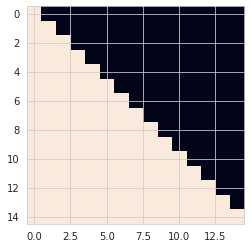

In [28]:
plt.figure(figsize=(4,4))
plt.imshow(get_lookahead_mask(15)[0])

In [0]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = get_masked_padding(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = get_masked_padding(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the decoder input
  look_ahead_mask = get_lookahead_mask(tar.shape[1])
  dec_target_padding_mask = get_masked_padding(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

## SingleHead Attention

In [0]:
def SingleHeadAttention(query, key, value, mask=None):
    """
    query - (batch_size, query_len, embedding_size)
    key - (batch_size, value_len, embedding_size)
    value - (batch_size, value_len, embedding_size)
    """
    
    # Step 1 - Matrix multiplication between query and key
    # weights --> (batch_size, query_len, value_len)
    weights = tf.matmul(query, key, transpose_b=True)

    # Step 2 - Weights Normalization
    # weights --> (batch_size, query_len, value_len)
    dim = key.shape[-1]
    weights = weights/np.sqrt(dim)
    
    if mask is not None:
        weights += (mask*-1e9) 

    # Step 3 - Softmax scores
    # weights --> (batch_size, query_len, value_len)
    weights = tf.nn.softmax(weights, axis=-1)
    
    # Step 4 - Context Vector
    # context --> (batch_size, query_len, embedding_size)
    context = tf.matmul(weights, value)
    
    return weights, context

## Custom Layers in TF
1. A layer encapsulates both a state (the layer's "weights") and a transformation from inputs to outputs (a "call", the layer's forward pass).
2. Layers can have non-trainable weights
3. ***If you assign a Layer instance as attribute of another Layer, the outer layer will start tracking the weights of the inner layer.*** For example, Encoder layer below tracks the weight matrices $W_{k}, W_{q}, W_{v}$ of the MultiHeadAttention layer called within it.


### Privileged training argument in the call method 

Some layers, in particular the BatchNormalization layer and the Dropout layer, have different behaviors during training and inference. For such layers, it is standard practice to expose a training (boolean) argument in the call method.

By exposing this argument in call, you enable the built-in training and evaluation loops (e.g. fit) to correctly use the layer in training and inference.

## MutliHead Attention

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model):
        super(MultiHeadAttention, self).__init__()
        # Step 1 - Create 4 matrix Wq, Wk, Wv
        # creates a kernel of size [embedding_size, d_model]
        self.Wq = Dense(d_model)
        self.Wk = Dense(d_model)
        self.Wv = Dense(d_model)
        self.Wo = Dense(d_model)

        self.num_heads = num_heads
        self.d_model = d_model
    
    def call(self, query, key, value, mask):
        # Step 2 - Perform linear transformation
        # query --> (batch_size, query_len, d_model)
        query = self.Wq(query)
        # key --> (batch_size, value_len, d_model)
        key = self.Wk(key)
        # value --> (batch_size, value_len, d_model)
        value = self.Wv(value)
        
        '''
        Step 3 - Reshape query,key and value. 
        Transform 3D matrix to 4D matrix by breaking along the last axis & then transpose.
        '''
        assert self.d_model % self.num_heads == 0
        depth = self.d_model//self.num_heads
        # query --> (batch_size, query_len, num_heads, depth)
        query = tf.reshape(query, (query.shape[0], query.shape[1], 
                                   self.num_heads, depth))
        # query --> (batch_size, num_heads, query_len, depth)
        query = tf.transpose(query, (0, 2, 1, 3))

        # key --> (batch_size, value_len, num_heads, depth)    
        key = tf.reshape(key, (key.shape[0], key.shape[1], 
                               self.num_heads, depth))
        # key --> (batch_size, num_heads, query_len, depth)
        key = tf.transpose(key, (0, 2, 1, 3))

        # value --> (batch_size, value_len, num_heads, depth)
        value = tf.reshape(value, (value.shape[0], value.shape[1], 
                                   self.num_heads, depth))
        # value --> (batch_size, num_heads, query_len, depth)
        value = tf.transpose(value, (0, 2, 1, 3))
        
        # Step 4 - Apply ScaledDotProduct (SingleHeadAttention) on each of the heads
        attention_weights, context_vector = SingleHeadAttention(query, key, value, mask)
        # context_vector --> (batch_size, query_len, num_heads, depth)
        context_vector = tf.transpose(context_vector, (0, 2, 1, 3))
        
        # Step 5 - Concatenate along the `num_heads` axis
        # context_vector --> (batch_size, query_len, d_model)    
        context_vector = tf.reshape(context_vector, 
                                    (context_vector.shape[0], context_vector.shape[1], self.d_model))
        
        # Step 6 - Apply linear transformation by multiplication with Wo
        context_vector = self.Wo(context_vector)
        return attention_weights, context_vector

## PointWise FeedForward Network

In [0]:
class FeedForwardNetwork(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super(FeedForwardNetwork, self).__init__()
        self.dense1 = Dense(dff, activation='relu')
        self.dense2 = Dense(d_model)
    
    def call(self, x):
        out = self.dense1(x)
        out = self.dense2(out)
        return out

## Encoder Layer

In [0]:
class SingleEncoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, dff):
        super(SingleEncoder, self).__init__()
        self.mulitheadattn = MultiHeadAttention(num_heads, d_model)
        self.feed_fwd_net = FeedForwardNetwork(d_model, dff)
        self.dropout1 = Dropout(0.1)
        self.dropout2 = Dropout(0.1)
        self.layer_norm1 = LayerNormalization()
        self.layer_norm2 = LayerNormalization()

    def call(self, query, key, value, training, mask):
        # Step 1 - MultiHeadAttention
        weights, context_vector = self.mulitheadattn(query, key, value, mask)
        
        # Dropout
        context_vector = self.dropout1(context_vector, training=training)
        
        # Step 2 - Normalize (x+attention(x))
        context_vector = self.layer_norm1(query+context_vector)
        
        # Step 3 - Pointwise FeedForward Network
        ffn_out = self.feed_fwd_net(context_vector)
        
        # Dropout
        ffn_out = self.dropout2(ffn_out, training=training)
        
        # Step 4 - Normalization again
        encoder_out = self.layer_norm2(context_vector+ffn_out)
        
        return encoder_out


## Encoder

In [0]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, 
                 input_vocab_size, max_len):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_len, d_model)
        self.pos_encoding = self.pos_encoding[np.newaxis, ...]
        self.dropout = Dropout(0.1)
        self.encoder_layers = [SingleEncoder(num_heads, d_model, dff) for x in range(num_heads)]

    def call(self, x, training, mask):
        seq_len = x.shape[1]

        x = self.embedding(x)
        x *= np.sqrt(self.d_model)
        # embedding+pos_encoding
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)

        # calling a single encoder layer `num_heads` times
        for single_encoder in self.encoder_layers:
            x = single_encoder(x, x, x, training, mask)

        return x

## Decoder Layer

In [0]:
class SingleDecoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, dff):
        super(SingleDecoder, self).__init__()

        self.mulitheadattn1 = MultiHeadAttention(num_heads, d_model)
        self.mulitheadattn2 = MultiHeadAttention(num_heads, d_model)
        self.feed_fwd_net = FeedForwardNetwork(d_model, dff)
        self.dropout1 = Dropout(0.1)
        self.dropout2 = Dropout(0.1)
        self.dropout3 = Dropout(0.1)
        self.layer_norm1 = LayerNormalization()
        self.layer_norm2 = LayerNormalization()
        self.layer_norm3 = LayerNormalization()

    def call(self, query, key, value, 
             encoder_out, look_ahead_mask, padding_mask):
        # Step 1 - MultiHeadAttention
        weights1, context_vector1 = self.mulitheadattn1(query, key, value, look_ahead_mask)
        
        # First Dropout
        context_vector1 = self.dropout1(context_vector1)
        
        # Step 2 - Normalize (x+mha_attention1(x))
        context_vector1 = self.layer_norm1(query+context_vector1)

        # Step 3 - MultiHeadAttention. Here, the encoder_output is the Key & Value, 
        # while the ContextVector from previous MultiHeadAttention is Query
        weights2, context_vector2 = self.mulitheadattn2(context_vector1, encoder_out, 
                                              encoder_out, padding_mask)
        
        # Second Dropout
        context_vector2 = self.dropout2(context_vector2)
        
        # Step 4 - Normalize(mha_attention1(x)+mha_attention2(mha_attention1(x), encoder_output))
        context_vector2 = self.layer_norm2(context_vector1+context_vector2)

        # Step 5 - Pointwise FeedForward Network
        ffn_out = self.feed_fwd_net(context_vector2)
        
        # Third Dropout
        ffn_out = self.dropout3(ffn_out)
        
        # Step 4 - Normalization again
        decoder_out = self.layer_norm3(context_vector2+ffn_out)
        
        return decoder_out


## Decoder

In [0]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, 
                 target_vocab_size, max_len):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.embedding = Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_len, d_model)
        self.pos_encoding = self.pos_encoding[np.newaxis, ...]
        self.dropout = Dropout(0.1)
        self.decoder_layers = [SingleDecoder(num_heads, d_model, dff) for x in range(num_heads)]
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = x.shape[1]

        x = self.embedding(x)
        x *= np.sqrt(self.d_model)
        # embedding+pos_encoding
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        # calling a single decoder layer `num_heads` times
        for single_decoder in self.decoder_layers:
            x = single_decoder(x, x, x, enc_output, 
                               look_ahead_mask, padding_mask)
           
        return x


## Transformer

In [0]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                 target_vocab_size, num_encoder_tokens, num_decoder_tokens):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, num_encoder_tokens)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, num_decoder_tokens)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
             look_ahead_mask, dec_padding_mask):
    
        # (batch_size, inp_seq_len, d_model)
        enc_output = self.encoder(inp, training, enc_padding_mask)  

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        # (batch_size, tar_seq_len, target_vocab_size)
        final_output = self.final_layer(dec_output)

        return final_output


In [0]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

# <START> & <END> token
input_vocab_size = num_encoder_tokens + 2
target_vocab_size = num_decoder_tokens + 2
dropout_rate = 0.1

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          num_encoder_tokens, 
                          num_decoder_tokens)

## Data Generator

In [0]:
def generate_batch(X=X_train, y=y_train, batch_size=128):
    ''' Returns a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src), dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar), dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar), dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    # encoder input seq
                    encoder_input_data[i, t] = input_token_index[word]
                target_words = target_text.split()
                for t, word in enumerate(target_words[:-1]):
                    # decoder input seq
                    decoder_input_data[i, t] = target_token_index[word] 
                for t, word in enumerate(target_words[1:]):
                    # decoder output seq
                    decoder_target_data[i, t] = target_token_index[word] 
            return (encoder_input_data, decoder_input_data, decoder_target_data)

## Loss & Optimizer

In [0]:
crossentropy = SparseCategoricalCrossentropy(from_logits=True)
def loss_func(targets, logits):
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)
    return loss

In [0]:
def train_func(targets, predictions):
    acc_func = SparseCategoricalAccuracy()
    acc = acc_func(targets, predictions)
    return acc

In [0]:
optimizer = tf.keras.optimizers.Adam()

## Training

In [0]:
EPOCHS = 20
BATCH_SIZE = 128

In [0]:
encoder_input_data, decoder_input_data, decoder_target_data = generate_batch(X_train, y_train, len(X_train))

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data, 
                                             decoder_input_data, 
                                             decoder_target_data))
dataset = dataset.shuffle(20).batch(BATCH_SIZE)

In [0]:
@tf.function
def train_step(src_seq, tar_seq_in, tar_seq_out):
    enc_inp_mask, combined_mask, dec_inp_mask = create_masks(src_seq, 
                                                             tar_seq_in)

    with tf.GradientTape() as tape:
        predictions = transformer(src_seq, tar_seq_in, 
                                 True, 
                                 enc_inp_mask, 
                                 combined_mask, 
                                 dec_inp_mask)
        loss = loss_func(tar_seq_out, predictions)
        acc = train_func(tar_seq_out, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    return loss, acc

In [48]:
for epoch in range(EPOCHS):
    for batch, (src_seq, tar_seq_in, tar_seq_out) in tqdm(enumerate(dataset.take(-1))):
        loss, acc = train_step(src_seq, tar_seq_in, tar_seq_out)
    print (f'Epoch {epoch} Loss {loss:.4f} Accuracy {acc:.4f}')


Epoch 0 Loss 0.7440 Accuracy 0.0270



Epoch 1 Loss 0.7414 Accuracy 0.0253



Epoch 2 Loss 0.7215 Accuracy 0.0242


KeyboardInterrupt: ignored